In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Importing Libraries

To start with the competition, we first need to import the necessary libraries. We'll be using XGBoost as our primary model, along with several other essential libraries for data manipulation, visualization, and evaluation.


In [2]:
# Data manipulation and numerical operations
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# XGBoost
from xgboost import XGBClassifier

# Warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Loading the Dataset

Next, we will load the training dataset from the provided path. This dataset contains the personal records of passengers from the Spaceship Titanic, which we'll use to train our model.

In [3]:
# Load the training dataset
train_df = pd.read_csv("train.csv")

# Display the first few rows of the training dataset
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Understanding the Dataset Structure

After loading the dataset, we previewed the first few rows to understand its structure. Below is a brief explanation of the columns:

- **PassengerId**: A unique identifier for each passenger, where the format `gggg_pp` indicates the group and passenger number within that group.
- **HomePlanet**: The planet from which the passenger departed.
- **CryoSleep**: Indicates if the passenger opted for cryosleep during the journey.
- **Cabin**: The cabin number where the passenger stayed, with the format `deck/num/side`.
- **Destination**: The intended destination planet of the passenger.
- **Age**: The age of the passenger.
- **VIP**: Indicates if the passenger paid for VIP services.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**: Amounts billed by the passenger at various luxury amenities on the spaceship.
- **Name**: The full name of the passenger.
- **Transported**: The target variable, indicating whether the passenger was transported to another dimension (`True` or `False`).

This initial look at the data helps us understand the different features available for model training and the target variable we need to predict.


In [4]:
train_df.shape

(8693, 14)

## Dataset Dimensions

The dataset has a shape of **(8693, 14)**, which provides important information about the number of records and features available for analysis:

- **Rows (8693)**: This represents the number of passenger records in the dataset. Each row corresponds to an individual passenger's details.
- **Columns (14)**: This indicates the number of features, including both input features (e.g., `HomePlanet`, `Age`, `VIP`) and the target variable (`Transported`). These features will be used to train the machine learning model.

Understanding the dimensions of the dataset is crucial for planning data preprocessing, feature engineering, and model training.


## Descriptive Statistics of the Dataset

To gain a quick statistical overview of the dataset, we use the `describe()` function. This function provides summary statistics for numerical columns in the DataFrame.


In [5]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


## Descriptive Statistics Overview

The table below provides a summary of the descriptive statistics for selected numerical features in the dataset, including `Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck`.

### Key Statistics:

- **Count**: 
  - The number of non-null entries for each feature. For instance, `Age` has 8514 non-null entries, indicating a few missing values in the dataset.

- **Mean**:
  - The average value for each feature. For example, the average age of passengers is approximately 28.83 years, while the average amount spent on `RoomService` is 224.69.

- **Standard Deviation (std)**:
  - Indicates the spread of values from the mean. Higher standard deviations, like 1611.49 for `FoodCourt`, suggest greater variability in spending among passengers.

- **Minimum (min)**:
  - The smallest recorded value for each feature. All features have a minimum value of 0, indicating that some passengers did not utilize these services.

- **Quartiles (25%, 50%, 75%)**:
  - These percentiles provide insight into the distribution of the data:
    - **25%**: The first quartile, indicating that 25% of the values are below this point.
    - **50% (Median)**: The middle value, dividing the data into two equal halves.
    - **75%**: The third quartile, indicating that 75% of the values are below this point.

- **Maximum (max)**:
  - The largest value recorded for each feature, showing the highest amounts spent or the oldest age.

### Insights:
- Many passengers have a zero expenditure across luxury services (`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`), as indicated by the 25th and 50th percentiles being 0.
- The wide range of values, particularly in the maximums, suggests that some passengers spent significantly more on these services than others.

Understanding these statistics helps in identifying trends, outliers, and potential areas for data preprocessing.


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## DataFrame Information

The `info()` function provides the following details about the DataFrame:

- **Entries**: 8693 rows.
- **Columns**: 14 columns with varying data types:
  - **Object**: `PassengerId`, `HomePlanet`, `CryoSleep`, `Cabin`, `Destination`, `VIP`, `Name`
  - **Float64**: `Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`
  - **Bool**: `Transported`
- **Missing Values**: Some columns have missing data, e.g., `HomePlanet` has 201 missing entries.
- **Memory Usage**: Approximately 891.5 KB.

This summary helps identify data types and missing values, guiding preprocessing steps.


## 3. Missing Values Analysis

### (i). Identify Missing Data
First, we need to assess which columns in the dataset have missing values and determine the proportion of missing values in each column. This step helps us understand the extent of missing data and its potential impact on our model.

### (ii). Handle Missing Data
After identifying the missing values, we decide on strategies for imputation or handling these missing values. Common strategies include:
- **Imputation**: Filling in missing values with a specific value such as the mean, median, or mode for numerical features, or using the most frequent value or a placeholder for categorical features.
- **Other Methods**: Depending on the situation, more advanced techniques such as interpolation or model-based imputation might be used.

In this analysis, we will focus on imputing missing values rather than dropping columns or rows to maintain as much data as possible.


In [6]:
# Identify Missing Data
missing_data = train_df.isnull().sum()
missing_proportion = (missing_data / len(train_df)) * 100
missing_summary = pd.DataFrame({
    'Missing Values' : missing_data,
    'Proportion (%)' : missing_proportion
})

print("### Missing Values Summary")
print(missing_summary[missing_summary['Missing Values'] > 0])

### Missing Values Summary
              Missing Values  Proportion (%)
HomePlanet               201        2.312205
CryoSleep                217        2.496261
Cabin                    199        2.289198
Destination              182        2.093639
Age                      179        2.059128
VIP                      203        2.335212
RoomService              181        2.082135
FoodCourt                183        2.105142
ShoppingMall             208        2.392730
Spa                      183        2.105142
VRDeck                   188        2.162660
Name                     200        2.300702


### Analysis:
- **Proportion of Missing Data**: Missing data is spread across several columns, with proportions ranging from approximately 2.06% to 2.50%. 
- **Impact**: While these percentages are relatively small, they could still impact the performance of the model. 

### Next Steps:
- **Imputation**: We will proceed to impute the missing values. For categorical features, we'll use the most frequent value, and for numerical features, we'll use the median. This approach ensures that we retain as much data as possible for model training.


In [7]:
# Handle Missing Data
# Impute missing values for categorical features
categorical_features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_df[categorical_features] = categorical_imputer.fit_transform(train_df[categorical_features])

# Impute missing values for numerical features
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
numerical_imputer = SimpleImputer(strategy='median')
train_df[numerical_features] = numerical_imputer.fit_transform(train_df[numerical_features])

# Verify that there are no missing values left
missing_data_after_imputation = train_df.isnull().sum()
print("\n### Missing Values After Imputation")
print(missing_data_after_imputation[missing_data_after_imputation > 0])


### Missing Values After Imputation
Series([], dtype: int64)


## Missing Values After Imputation

After applying the imputation strategies, there are no missing values remaining in the dataset. The missing values have been successfully handled for both categorical and numerical features.

### Summary:
- **No Missing Values**: The dataset is now complete with no missing entries in any column, which ensures that all available data can be used for building and training the model.

### Next Steps:
- **Proceed with Data Analysis**: With missing values addressed, we can now move forward with further exploratory data analysis (EDA) and feature engineering.
- **Model Building**: The cleaned dataset can be used to build and train models, including XGBoost, to predict whether passengers were transported to an alternate dimension.


## 4. Exploratory Data Analysis (EDA) 

Will helps us understand the dataset and uncover insights that can inform your modeling process. 

## (i). Univariate Analysis: Age Distribution

The following code generates a histogram of the passengers' ages with a Kernel Density Estimate (KDE) overlay. This visualization provides insights into the age distribution of the passengers on the Spaceship Titanic.


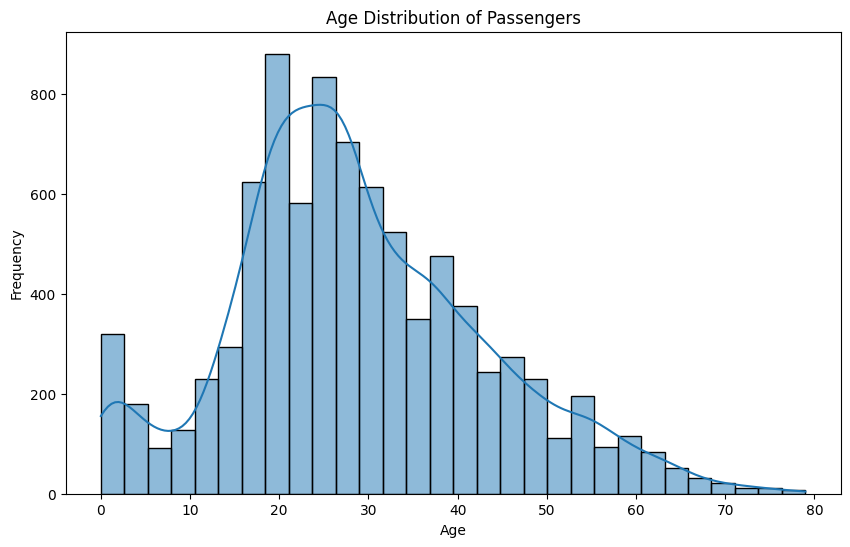

In [8]:
# Univariate Analysis
## Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Age'], bins=30, kde=True)
plt.title('Age Distribution of Passengers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## (ii). Categorical Feature Distributions

The following code generates count plots for several categorical features in the dataset. Each plot visualizes the frequency distribution of values for the specified categorical variables.


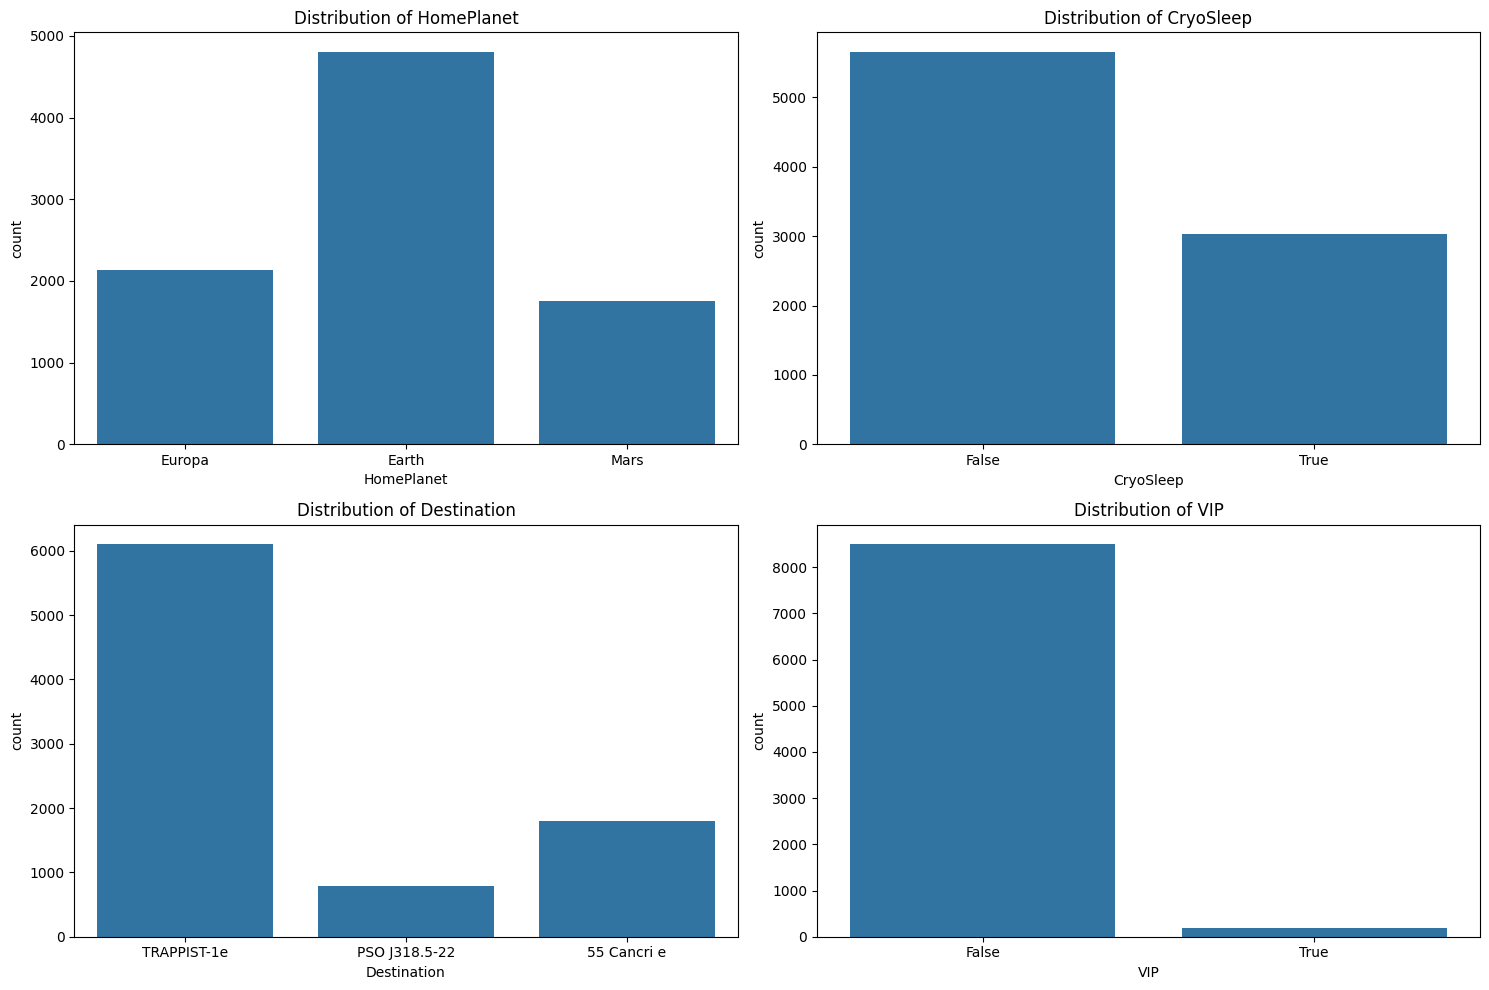

In [9]:
## Categorical Feature Distributions
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=feature, data=train_df)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

## Insights from Categorical Feature Distributions

### HomePlanet
- **Earth**: Most common, indicating a bias towards Earth-based passengers. Ensure the model handles this bias.
- **Europa and Mars**: Less frequent. Address potential class imbalance in these categories.

### CryoSleep
- **False**: Majority of passengers did not opt for CryoSleep. Handle the smaller True category carefully.
- **True**: Consider special handling due to its smaller size in the dataset.

### Destination
- **TRAPPIST-1e**: Most frequent destination. Ensure the model effectively handles this dominant category.
- **55 Cancri e and PSO J318.5-22**: Address the lesser representation to ensure fair predictions.

### VIP
- **False**: Dominates with a high count. Ensure the model recognizes the impact of VIP status despite its rarity.
- **True**: Rare category, requiring careful consideration to avoid model bias.



## (iii). Target Distribution

The following code generates a count plot for the `Transported` feature, which shows the distribution of passengers who were transported versus those who were not. This visualization helps assess the balance between the target classes and is essential for understanding any potential class imbalance in the dataset.


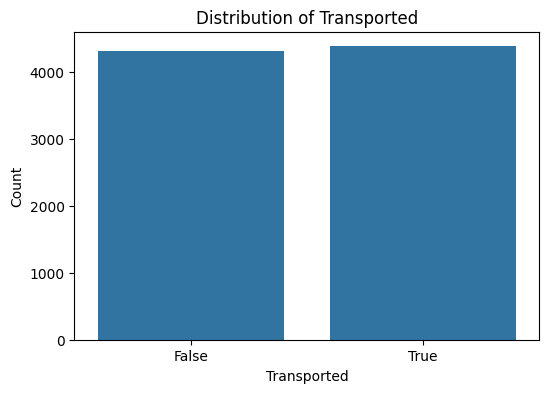

In [10]:
# Bivariate Analysis
## Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', data=train_df)
plt.title('Distribution of Transported')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()

From the plot, it can be observed that the number of passengers who were transported (`True`) is slightly higher than those who were not transported (`False`). This indicates a slight imbalance in the dataset, which may need to be considered during model training.


## (iv). Age vs Transported

The following code generates a box plot showing the distribution of `Age` for passengers who were transported versus those who were not. This visualization helps to understand how age varies between the two groups and can reveal any potential differences in age distribution that might impact the target variable.

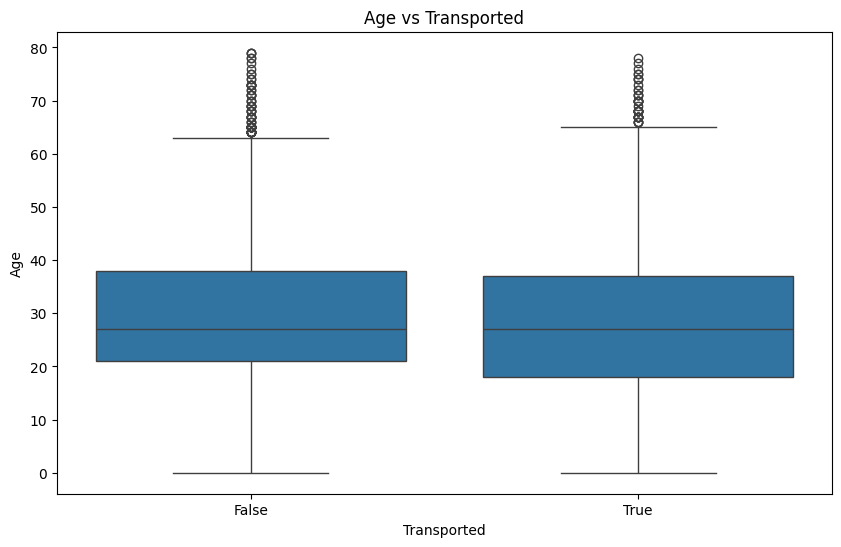

In [11]:
## Age vs Transported
plt.figure(figsize=(10, 6))
sns.boxplot(x='Transported', y='Age', data=train_df)
plt.title('Age vs Transported')
plt.xlabel('Transported')
plt.ylabel('Age')
plt.show()

## (v). Amenities vs Transported

The following code generates box plots for various amenities (`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`) in relation to the `Transported` feature. Each plot shows the distribution of the specified amenity expenditure for passengers who were transported versus those who were not. This visualization helps to understand how the usage of different amenities might be associated with the likelihood of being transported.


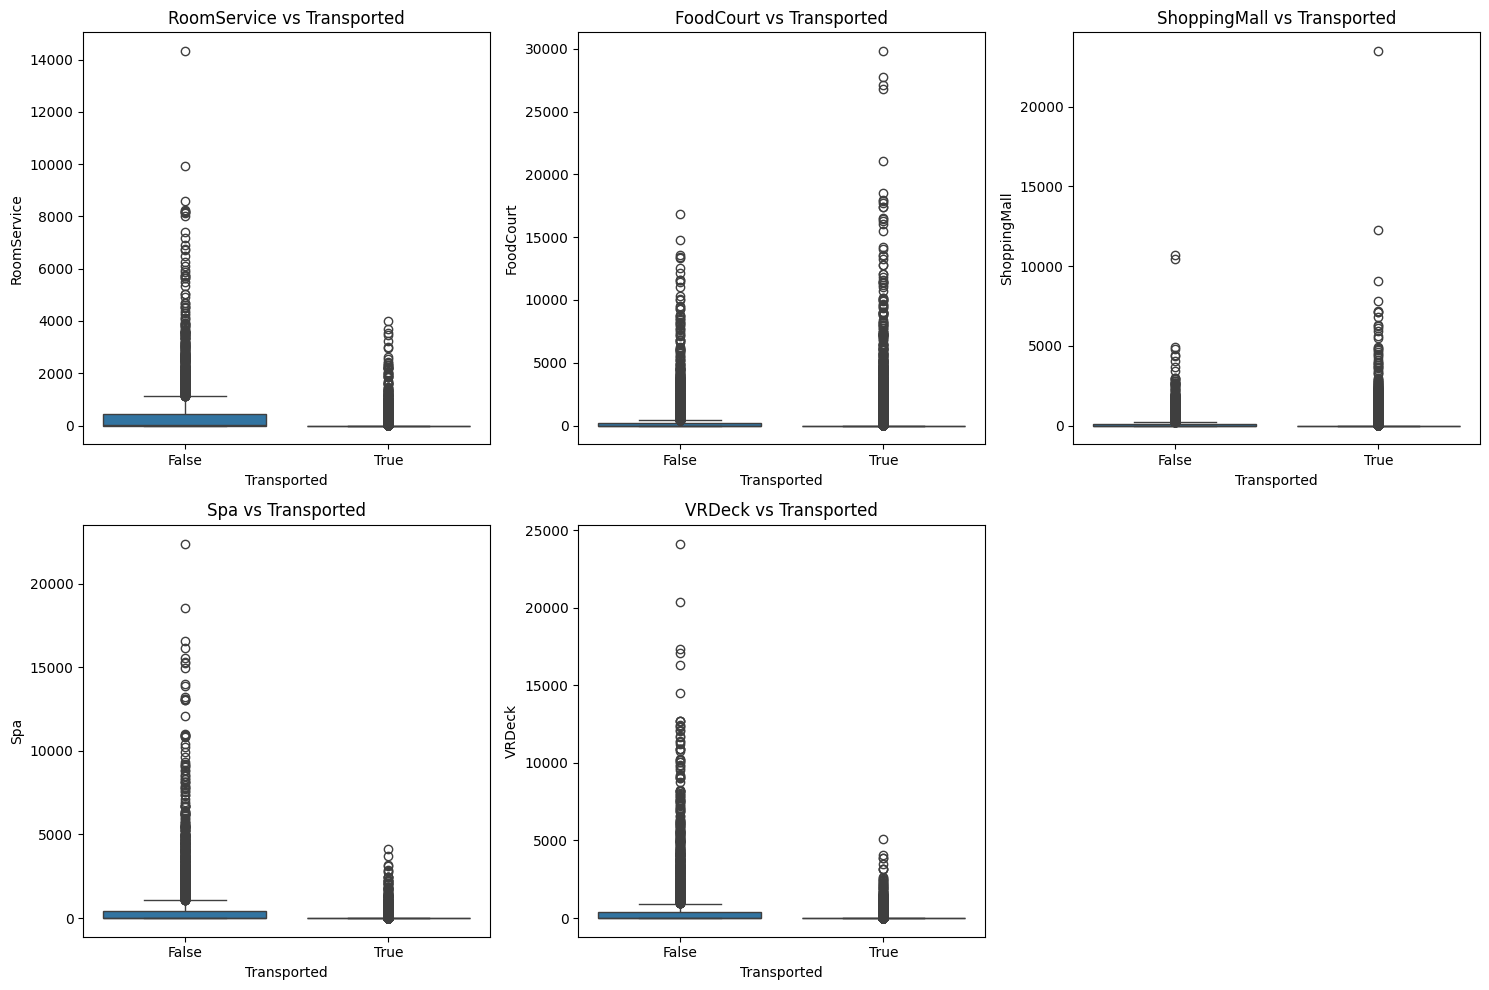

In [12]:
## Amenities vs Transported
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
plt.figure(figsize=(15, 10))
for i, amenity in enumerate(amenities, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Transported', y=amenity, data=train_df)
    plt.title(f'{amenity} vs Transported')
plt.tight_layout()
plt.show()

## 5. Data Preprocessing Implementation

1. **Feature Encoding**
   - We’ll use both **one-hot encoding** for categorical variables and **label encoding** for binary categorical features.

2. **Feature Scaling**
   - Standardize numerical features to ensure they have a mean of 0 and a standard deviation of 1.

3. **Feature Engineering**
   - Create new feature or modify existing ones to improve model performance. 


In [13]:
# Define preprocessing functions

def create_age_bins(df):
    """
    Create age bins for the 'Age' column.
    """
    bins = [0, 18, 30, 40, 50, 60, 100]
    labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '60+']
    df['Age_Bin'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    return df

In [14]:
# Apply feature engineering
train_df = create_age_bins(train_df)

In [15]:
# Define categorical and numerical features
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Age_Bin']
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Define preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())  # Scale numerical features
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [16]:
# Preprocess training data
X = preprocessor.fit_transform(train_df.drop(columns=['Transported']))
y = train_df['Transported']


# Display the shape of the preprocessed data
print(f"Preprocessed data shape: {X.shape}")

Preprocessed data shape: (8693, 22)


## 6. Model Training and Evaluation

In this step, we will:

1. **Initialize the Model**: Set up the XGBoost classifier with the specified parameters.

2. **Hyperparameter Tuning**: Use `GridSearchCV` to identify the best hyperparameters for the XGBoost model.

3. **Train the Model**: Fit the model with the best hyperparameters on the entire preprocessed training dataset.

4. **Prepare Test Data**: Load and preprocess the test dataset to ensure it has the same features as the training data.

5. **Generate Predictions**: Use the trained model to make predictions on the test dataset.

6. **Create Submission File**: Save the predictions to a CSV file for submission.


In [17]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [19]:
# Get the best model
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X, y)

# Load and preprocess test data
test_df = pd.read_csv('test.csv')
test_df = create_age_bins(test_df)

# Ensure test_df has the same columns as train_df
for col in categorical_features + numerical_features:
    if col not in test_df.columns:
        if col in categorical_features:
            test_df[col] = 'unknown'  # Use a placeholder for missing categorical columns
        else:
            test_df[col] = 0  # Default value for missing numerical columns

test_X = preprocessor.transform(test_df)

# Predict on the test dataset
test_predictions = best_model.predict(test_X)

In [20]:
# Create submission file
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': test_predictions
})

submission.to_csv('submission.csv', index=False)

print("Submission file created.")

Submission file created.


In [21]:
submission.head()

,PassengerId,Transported
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1
